# Ontology closest category evaluation

In [25]:
from graphai.core.common.ontology_utils.data import OntologyData
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ontology_data = OntologyData(test_mode=True, test_ratio=0.3, random_state=20)
ontology_data.load_data()

1497301 1497301 1497301


Let's see the size of the test and training sets:

In [3]:
print(ontology_data.get_test_category_concept().shape[0], ontology_data.get_category_concept_table().shape[0])

5921 13818


In [4]:
test_category_concept = ontology_data.get_test_category_concept()
test_concepts = test_category_concept['to_id'].values.tolist()
test_labels = test_category_concept['from_id'].values.tolist()

In [5]:
def predict_all(model: OntologyData, x: list, avg='linear', coeffs=(1, 4), top_down=True, n=5):
    y = list()
    for p in x:
        best_cats, best_scores, selected_d3_category, best_clusters = \
            model.get_concept_closest_category(p, avg=avg, coeffs=coeffs, top_n=n, use_depth_3=top_down,
                                               return_clusters=None)
        if best_cats is None:
            best_cats = list()
        y.append(best_cats)
    return y

def get_top_k_list_of_lists(res, k):
    max_k = max([len(x) for x in res])
    if k > max_k:
        print('Maximum n is %d, cannot return evaluation metrics @ %d' % (max_k, k))
        return None
    return [set(x[:k]) for x in res]

def eval_at_k(res, labels, k):
    results_to_evaluate = get_top_k_list_of_lists(res, k)
    n_correct = sum([1 if labels[i] in results_to_evaluate[i] else 0 for i in range(len(results_to_evaluate))])
    n_total = len(labels)
    acc = n_correct / n_total
    return acc

def get_errors_at_k(res, concepts, labels, k):
    results_to_evaluate = get_top_k_list_of_lists(res, k)
    error_indices = [i for i in range(len(results_to_evaluate)) if labels[i] not in results_to_evaluate[i]]
    return [concepts[i] for i in error_indices]

def get_max_accuracy(res):
    return len([x for x in res if len(x) > 0]) / len(res)
    

## Evaluating different combinations

In [6]:
parameter_list = list(
    itertools.product(['log', 'linear'], [(1, 1), (10, 1), (1, 10), (1, 100), (0, 1)],
                      [False, True])
)

In [7]:
all_results = [
    predict_all(ontology_data, test_concepts, avg=params[0], coeffs=params[1], top_down=params[2], n=10)
    for params in parameter_list
]

In [8]:
all_eval_at_1 = [eval_at_k(results, test_labels, 1) for results in all_results]

In [9]:
all_eval_at_5 = [eval_at_k(results, test_labels, 5) for results in all_results]

In [10]:
all_eval_at_10 = [eval_at_k(results, test_labels, 10) for results in all_results]

In [11]:
all_max_acc = [get_max_accuracy(results) for results in all_results]

### Results

#### Accuracy @ 1

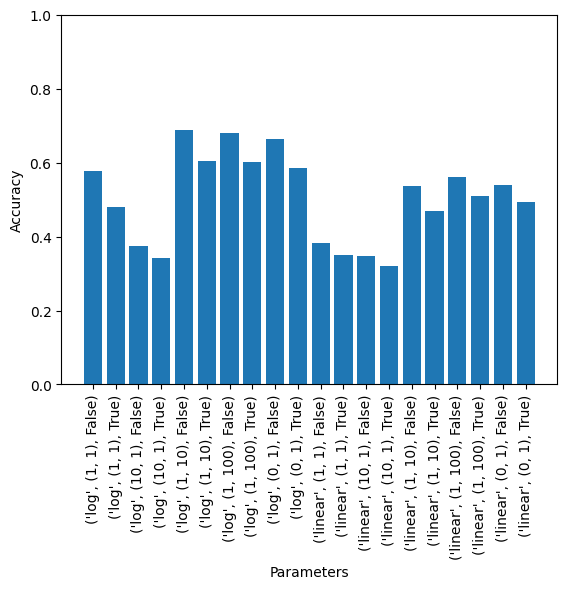

In [12]:
plt.bar([str(x) for x in parameter_list], height=all_eval_at_1)
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Parameters')
plt.ylim([0, 1])
plt.show()

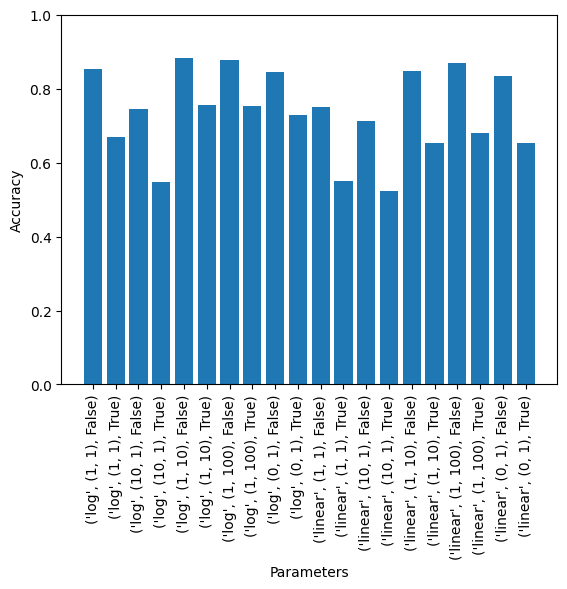

In [13]:
plt.bar([str(x) for x in parameter_list], height=all_eval_at_5)
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Parameters')
plt.ylim([0, 1])
plt.show()

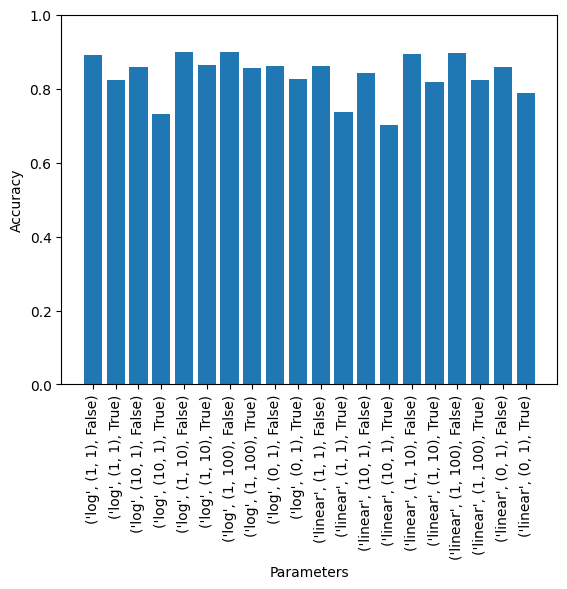

In [14]:
plt.bar([str(x) for x in parameter_list], height=all_eval_at_10)
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Parameters')
plt.ylim([0, 1])
plt.show()

Let's see the results for the best parameters:

Best params:

In [15]:
parameter_list[np.argmax(all_eval_at_1)]

('log', (1, 10), False)

Accuracy @1, @5 and @10:

In [16]:
all_eval_at_1[np.argmax(all_eval_at_1)], all_eval_at_5[np.argmax(all_eval_at_1)], all_eval_at_10[np.argmax(all_eval_at_1)]

(0.689072791758149, 0.8821145076845127, 0.8998479986488769)

What are the conclusions that we can draw here?
* log >>>>>>> linear
* Top-down search always makes the results worse
* Concepts are much more important than anchors, but anchor pages are useful after all and removing them or de-emphasizing them too much reduces accuracy.

#### Analyzing the errors

In [17]:
best_index = np.argmax(all_eval_at_1)
best_params = parameter_list[best_index]
best_results = all_results[best_index]

In [18]:
errors_at_5 = get_errors_at_k(best_results, test_concepts, test_labels, 5)

In [19]:
len(errors_at_5), len(test_labels)

(698, 5921)

In [20]:
test_concept_names = ontology_data.get_test_concept_names()
errors_at_5_concept_names = test_concept_names.loc[test_concept_names['id'].apply(lambda x: x in errors_at_5)]

In [21]:
errors_at_5_concept_names

,id,name
0,100034,Military engineering
32,10044864,Research question
50,1006651,Amorphous carbon
65,10096030,Informal education
112,1016556,Induced seismicity
...,...,...
19419,9553738,Ensemble Kalman filter
19558,9764915,Bicarbonate buffer system
19591,9801859,Marketplace
19622,9848870,Energy efficiency in transport


In [30]:
errors_at_5_categories = test_category_concept.loc[test_category_concept.to_id.apply(lambda x: x in errors_at_5)]
errors_at_5_categories = errors_at_5_categories.assign(count=1)[['from_id', 'count']].groupby('from_id').sum().reset_index()
category_full_sizes = pd.concat([ontology_data.get_test_category_concept(), ontology_data.get_category_concept_table()]).assign(count=1)[['from_id', 'count']].groupby('from_id').sum().reset_index()
category_test_sizes = test_category_concept.assign(count=1)[['from_id', 'count']].groupby('from_id').sum().reset_index()
errors_at_5_categories = pd.merge(errors_at_5_categories, category_full_sizes, how='inner',
                                  on='from_id', suffixes=('_errors', '_total'))
errors_at_5_categories = pd.merge(errors_at_5_categories, category_test_sizes, how='inner',
                                  on='from_id').rename(columns={'count': 'count_test'})
errors_at_5_categories['error_ratio'] = errors_at_5_categories['count_errors'] / errors_at_5_categories['count_test'] 

In [34]:
errors_at_5_categories.sort_values(by=['error_ratio', 'count_errors'], ascending=False)

,from_id,count_errors,count_total,count_test,error_ratio
294,topics-in-geology,17,40,17,1.000000
161,interpreters,7,15,7,1.000000
95,ecosystem-ecology,6,19,6,1.000000
114,enzyme-kinetics,6,12,6,1.000000
215,plasma-engineering,6,18,6,1.000000
...,...,...,...,...,...
219,polymer-chemistry,1,113,39,0.025641
105,entities-in-astrophysics,1,154,40,0.025000
177,microprocessors,1,143,41,0.024390
2,abstract-algebra,1,151,51,0.019608
